In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.preprocessing import LabelEncoder

In [8]:
# Load dataset
df = pd.read_csv("survey.csv")

In [9]:
df

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2015-09-12 11:17:21,26,male,United Kingdom,NaN,No,No,Yes,NaN,26-100,...,Somewhat easy,No,No,Some of them,Some of them,No,No,Don't know,No,NaN
1255,2015-09-26 01:07:35,32,Male,United States,IL,No,Yes,Yes,Often,26-100,...,Somewhat difficult,No,No,Some of them,Yes,No,No,Yes,No,NaN
1256,2015-11-07 12:36:58,34,male,United States,CA,No,Yes,Yes,Sometimes,More than 1000,...,Somewhat difficult,Yes,Yes,No,No,No,No,No,No,NaN
1257,2015-11-30 21:25:06,46,f,United States,NC,No,No,No,NaN,100-500,...,Don't know,Yes,No,No,No,No,No,No,No,NaN


In [ ]:


# Drop irrelevant columns
df = df.drop(columns=['Timestamp', 'state', 'comments'], errors='ignore')

# Filter out invalid age values
df = df[(df['Age'] >= 18) & (df['Age'] <= 100)]

# Clean Gender column
def clean_gender(g):
    g = str(g).strip().lower()
    if g in ['male', 'm', 'man']:
        return 'Male'
    elif g in ['female', 'f', 'woman']:
        return 'Female'
    else:
        return 'Other'

df['Gender'] = df['Gender'].apply(clean_gender)

# Handle missing values safely (avoid chained assignment)
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

# Separate categorical and numerical columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Encode categorical columns
if int(sklearn.__version__.split(".")[1]) >= 2:
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
else:
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

encoded_cat = encoder.fit_transform(df[categorical_cols])
encoded_cat_df = pd.DataFrame(encoded_cat, columns=encoder.get_feature_names_out(categorical_cols))

# Normalize numerical columns
scaler = MinMaxScaler()
scaled_num = scaler.fit_transform(df[numerical_cols])
scaled_num_df = pd.DataFrame(scaled_num, columns=numerical_cols)

# Combine all processed features
processed_df = pd.concat([encoded_cat_df.reset_index(drop=True), scaled_num_df.reset_index(drop=True)], axis=1)


In [10]:
processed_df

,Gender_Female,Gender_Male,Gender_Other,Country_Australia,Country_Austria,Country_Belgium,Country_Bosnia and Herzegovina,Country_Brazil,Country_Bulgaria,Country_Canada,...,mental_health_interview_Yes,phys_health_interview_Maybe,phys_health_interview_No,phys_health_interview_Yes,mental_vs_physical_Don't know,mental_vs_physical_No,mental_vs_physical_Yes,obs_consequence_No,obs_consequence_Yes,Age
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.351852
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.481481
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.259259
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.240741
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.240741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1246,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.148148
1247,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.259259
1248,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.296296
1249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.518519


In [5]:
# Determine optimal number of clusters
inertia = []
sil_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(processed_df)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(processed_df, labels))

optimal_k = sil_scores.index(max(sil_scores)) + 2

# Final K-Means clustering
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_labels = final_kmeans.fit_predict(processed_df)

# PCA for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(processed_df)
reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
reduced_df['Cluster'] = final_labels

In [22]:
reduced_df['Cluster'] = list(map(lambda x: 'Rawan' if x else 'Tidak Rawan', reduced_df['Cluster']))

In [23]:
reduced_df

,PC1,PC2,Cluster
0,1.493252,0.771736,Tidak Rawan
1,-0.953745,-0.469981,Rawan
2,-0.908982,1.392566,Rawan
3,0.069582,-1.162710,Tidak Rawan
4,-0.269060,1.485922,Rawan
...,...,...,...
1246,-0.802082,0.199602,Rawan
1247,1.662870,0.275091,Tidak Rawan
1248,0.472857,-1.969331,Tidak Rawan
1249,-0.729078,-0.937885,Rawan


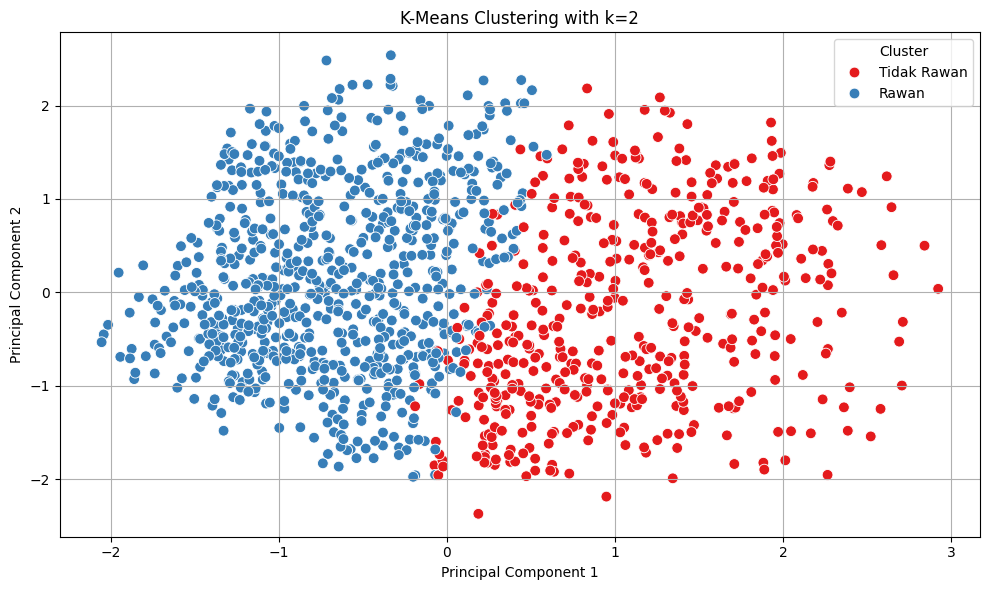

In [24]:
# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=reduced_df, x='PC1', y='PC2', hue='Cluster', palette='Set1', s=60)
plt.title(f'K-Means Clustering with k={optimal_k}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()
